In [1]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from shapley import SobolIndices, SobolKrigingIndices
from shapley.tests import Ishigami, AdditiveGaussian
from shapley.tests.utils import true_gaussian_full_ind_sobol
from shapley.plots import set_style_paper, plot_sensitivity_results

%load_ext autoreload
%autoreload 2

%matplotlib inline

set_style_paper()

savefigs = False
ylim = [-0.1, 1.]

## The Model

In [52]:
model = Ishigami()
dim = model.dim
model.copula = ot.NormalCopula(dim)

theta = [0., 0.0, 0.]
model.copula_parameters = theta

Full Sobol indices: [ 0.31117981  0.43783297 -0.02268432]
Full Total Sobol indices: [ 0.55205307  0.43431527  0.23570971]
Ind Sobol indices: [ 0.30340883  0.44233915  0.00788287]
Ind Total Sobol indices: [ 0.54392652  0.42914636  0.23903143]


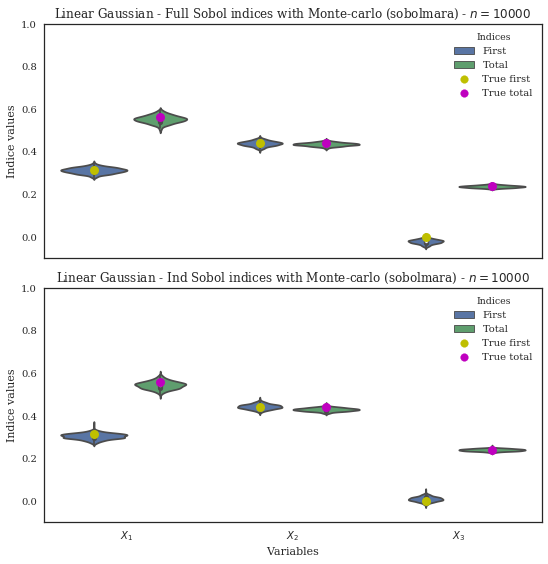

In [54]:
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

n_sample = 10000

# Evaluate the model
sobol = SobolIndices(model.input_distribution)
sobol.build_uncorrelated_mc_sample(model, n_sample)

n_boot = 500
estimator = 'sobolmara'
sobol_results_full = sobol.compute_full_indices(n_boot=n_boot, estimator=estimator)
sobol_results_ind = sobol.compute_ind_indices(n_boot=n_boot, estimator=estimator)

# Results
first_indices_full_mc = sobol_results_full.first_indices
total_indices_full_mc = sobol_results_full.total_indices
first_indices_ind_mc = sobol_results_ind.first_indices
total_indices_ind_mc = sobol_results_ind.total_indices

print("Full Sobol indices:", first_indices_full_mc)
print("Full Total Sobol indices:", total_indices_full_mc)
print("Ind Sobol indices:", first_indices_ind_mc)
print("Ind Total Sobol indices:", total_indices_ind_mc)

fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8, 8))
ax = axes[0]

sobol_results_full.true_first_indices = model.first_order_sobol_indices
sobol_results_full.true_total_indices = model.total_sobol_indices
sobol_results_ind.true_first_indices = model.first_order_sobol_indices
sobol_results_ind.true_total_indices = model.total_sobol_indices

plot_sensitivity_results(sobol_results_full, ax=ax)
ax.set_title("Linear Gaussian - Full Sobol indices with Monte-carlo (%s) - $n=%d$" % (estimator, n_sample))
ax.set_ylim(ylim)
ax.set_xlabel('')
    
ax = axes[1]

plot_sensitivity_results(sobol_results_ind, ax=ax)
ax.set_title("Linear Gaussian - Ind Sobol indices with Monte-carlo (%s) - $n=%d$" % (estimator, n_sample))
ax.set_ylim(ylim)
fig.tight_layout()
if savefigs:
    fig.savefig('./output/ishigami_dep_full_ind_theta_%d_n_%d_%s.pdf' % (id_theta, n_sample, estimator))

## Using a Kriging model to substitute the true model

### Building the model

In [30]:
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
model_budget = 50
basis = 'quadratic'
kernel = 'matern'
library = 'sklearn'
sampling = 'monte-carlo'
sobol_kriging = SobolKrigingIndices(model.input_distribution)
meta_model = sobol_kriging.build_meta_model(model, n_sample=model_budget, basis_type=basis, kernel=kernel, library=library, sampling=sampling)

### The quality of the kriging model

#### With Leave One Out

In [11]:
score_q2_loo = meta_model.compute_score_q2_loo()
print('Leave One Out Q2 score:', score_q2_loo)

C:\Users\naz-probook\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -9.00936977e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


Leave One Out Q2 score: 0.997245630349


#### With cross validation

In [12]:
n_sample_cv = 1000
score_q2_cv = meta_model.compute_score_q2_cv(n_sample_cv, sampling='monte-carlo')
print('Cross Validation Q2 score with %d observations:' % (n_sample_cv), score_q2_cv)

Cross Validation Q2 score with 1000 observations: 0.996260188637


### Estimating the indices

In [21]:
%%time
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
n_sample = 300
n_realization = 200

# Evaluate the kriging model
sobol_kriging.build_uncorrelated_mc_sample(meta_model, n_sample, n_realization)

Wall time: 1.72 s


In [22]:
%%time
n_boot = 500
estimator = 'sobolmara'
sobol_kriging_results_full = sobol_kriging.compute_full_indices(n_boot=n_boot, estimator=estimator)
sobol_kriging_results_ind = sobol_kriging.compute_ind_indices(n_boot=n_boot, estimator=estimator)

# Results
first_indices_full_gp = sobol_kriging_results_full.first_indices
total_indices_full_gp = sobol_kriging_results_full.total_indices
first_indices_ind_gp = sobol_kriging_results_ind.first_indices
total_indices_ind_gp = sobol_kriging_results_ind.total_indices

print("Full Sobol indices:", first_indices_full_gp)
print("Full Total Sobol indices:", first_indices_full_gp)
print("Ind Sobol indices:", first_indices_ind_gp)
print("Ind Total Sobol indices:", first_indices_ind_gp)

Full Sobol indices: [ 0.50385315  0.00716332  0.27491449]
Full Total Sobol indices: [ 0.50385315  0.00716332  0.27491449]
Ind Sobol indices: [ 0.598943    0.34279351  0.46521524]
Ind Total Sobol indices: [ 0.598943    0.34279351  0.46521524]
Wall time: 5.38 s


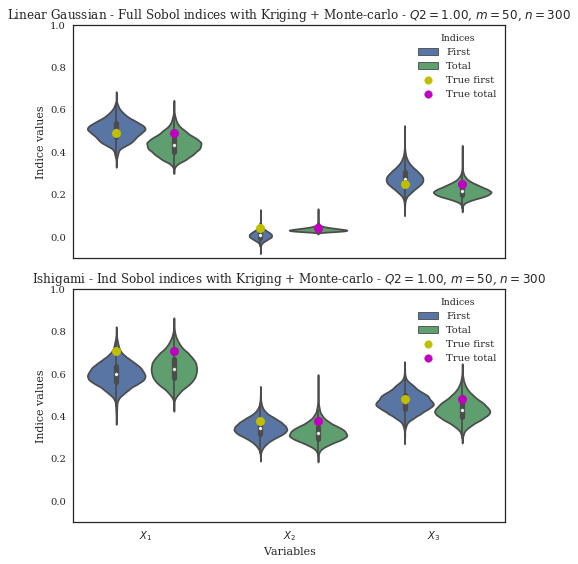

In [23]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8, 8))
ax = axes[0]

sobol_kriging_results_full.true_first_indices = true_full_indices
sobol_kriging_results_full.true_total_indices = true_full_indices

plot_sensitivity_results(sobol_kriging_results_full, indice='all', ax=ax)
ax.set_title("Linear Gaussian - Full Sobol indices with Kriging + Monte-carlo - $Q2=%.2f$, $m=%d$, $n=%d$" % (score_q2_cv, model_budget, n_sample))
ax.set_ylim(ylim)
ax.set_xlabel('')
    
ax = axes[1]
sobol_kriging_results_ind.true_first_indices = true_ind_indices
sobol_kriging_results_ind.true_total_indices = true_ind_indices

plot_sensitivity_results(sobol_kriging_results_ind, indice='all', ax=ax)
ax.set_title("Ishigami - Ind Sobol indices with Kriging + Monte-carlo - $Q2=%.2f$, $m=%d$, $n=%d$" % (score_q2_cv, model_budget, n_sample))
ax.set_ylim(ylim)
fig.tight_layout()
if savefigs:
    fig.savefig('./output/gaussian_dep_gp_full_ind_theta_%d_n_%d_%s.pdf' % (id_theta, n_sample, estimator))

#### Plots of the first indices with the kriging and monte-carlo errors

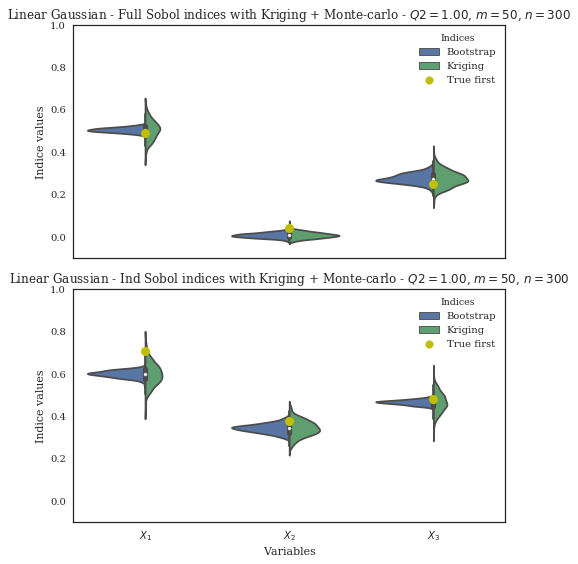

In [24]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8, 8))
ax = axes[0]

sobol_kriging_results_full.true_first_indices = true_full_indices
sobol_kriging_results_full.true_total_indices = true_full_indices

plot_sensitivity_results(sobol_kriging_results_full, indice='first', ax=ax)
ax.set_title("Linear Gaussian - Full Sobol indices with Kriging + Monte-carlo - $Q2=%.2f$, $m=%d$, $n=%d$" % (score_q2_cv, model_budget, n_sample))
ax.set_ylim(ylim)
ax.set_xlabel('')
    
ax = axes[1]
sobol_kriging_results_ind.true_first_indices = true_ind_indices
sobol_kriging_results_ind.true_total_indices = true_ind_indices

plot_sensitivity_results(sobol_kriging_results_ind, indice='first', ax=ax)
ax.set_title("Linear Gaussian - Ind Sobol indices with Kriging + Monte-carlo - $Q2=%.2f$, $m=%d$, $n=%d$" % (score_q2_cv, model_budget, n_sample))
ax.set_ylim(ylim)
fig.tight_layout()
if savefigs:
    fig.savefig('./output/gaussian_dep_gp_full_ind_var_theta_%d_n_%d_%s.pdf' % (id_theta, n_sample, estimator))

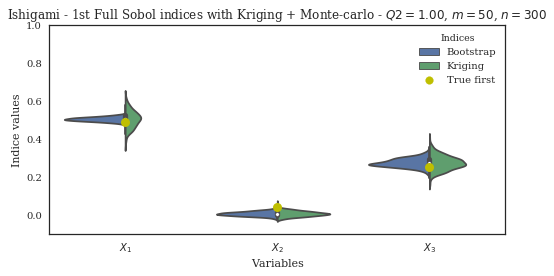

In [25]:
sobol_kriging_results_full.true_first_indices = true_full_indices
sobol_kriging_results_full.true_total_indices = true_full_indices

fig, ax = plt.subplots(figsize=(8, 4))
aa = plot_sensitivity_results(sobol_kriging_results_full, indice='first', ax=ax)
ax.set_ylim(ylim)
ax.set_title("Ishigami - 1st Full Sobol indices with Kriging + Monte-carlo - $Q2=%.2f$, $m=%d$, $n=%d$" % (score_q2_cv, model_budget, n_sample))
fig.tight_layout()
if savefigs:
    fig.savefig('./output/gaussian_gp_dep_full_1st_theta_%d_n_%d_%s.pdf' % (id_theta, n_sample, estimator))

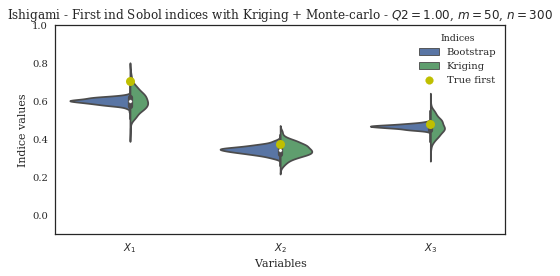

In [26]:
sobol_kriging_results_ind.true_first_indices = true_ind_indices
sobol_kriging_results_ind.true_total_indices = true_ind_indices

fig, ax = plt.subplots(figsize=(8, 4))
aa = plot_sensitivity_results(sobol_kriging_results_ind, indice='first', ax=ax)
ax.set_ylim(ylim)
ax.set_title("Ishigami - First ind Sobol indices with Kriging + Monte-carlo - $Q2=%.2f$, $m=%d$, $n=%d$" % (score_q2_cv, model_budget, n_sample))
fig.tight_layout()
if savefigs:
    fig.savefig('./output/gaussian_gp_dep_ind_1st_theta_%d_n_%d_%s.pdf' % (id_theta, n_sample, estimator))